# Data Mining - Project
## Profilling Notebook
## Group Members
|Name|StudentID|
|:-----------:|:--------:|
|Fabio Lopes|20200597|
|Filipe Costa|20201041|
|Jorge Pereira|20201085|


In [1]:
import sys
!{sys.executable} -m pip install pyshp

You should consider upgrading via the 'C:\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import shapefile as shp

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df_source = pd.read_csv('./data/donors.csv')
df_source.drop('Unnamed: 0', axis = 1, inplace = True)
df_fullLabeled = pd.read_csv('./Outputs/clustering_Labelled.csv')
df_tsne = pd.read_csv('./Outputs/clustering_tsne.csv')

C:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (9,412) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
def splitNumericAndCategorical(df):
    """Informs user on the total number of columns in the dataframe and splits it
       in 2 dataframes, one numerical and the other categorical."""
    df_num = df._get_numeric_data()
    df_cat = df.drop(df_num.columns, axis = 1)
    print(f"Total Columns: {df.shape[1]}")
    print(f"Numerical Columns: {df_num.shape[1]}")
    print(f"Categorical Columns: {df_cat.shape[1]}")
    return df_num,df_cat

# Cluster Profilling

In [6]:
df_profilling = df_fullLabeled.copy()

In [7]:
df_profilling.head()

,STATE,INCOME,WEALTH1,WWIIVETS,FEDGOV,WEALTH2,CARDPROM,CARDPM12,NUMPRM12,NGIFTALL,RFA_2F,elapsed_MINRDATE,elapsed_MAXRDATE,elapsed_LASTDATE,LASTGIFTAMOUNTCATEGORY,Cluster
0,IL,-0.266667,0.200000,-0.636364,-0.977011,0.111111,-0.133333,-0.368421,-0.662338,-0.745763,1.000000,-0.584386,-0.718758,0.217639,-0.333333,0
1,CA,0.666667,1.000000,-0.777778,-0.977011,1.000000,-0.633333,-0.368421,-0.688312,-0.983051,-0.333333,-0.692016,-0.890172,0.217639,1.000000,3
2,NC,-0.333333,-0.777778,-0.333333,-0.977011,-0.777778,-0.166667,-0.368421,-0.662338,-0.779661,1.000000,-0.515159,-0.569926,0.217639,-0.333333,0
3,CA,-1.000000,-0.111111,-0.373737,-0.931034,-1.000000,-0.133333,-0.368421,-0.662338,-0.872881,1.000000,-0.146033,-0.788812,0.217639,-0.333333,0
4,AL,-0.133333,0.111111,-0.535354,-0.862069,-0.200000,-0.533333,-0.368421,-0.714286,-0.974576,-1.000000,-0.760990,-0.796510,0.738265,0.333333,1


## Donors per Cluster

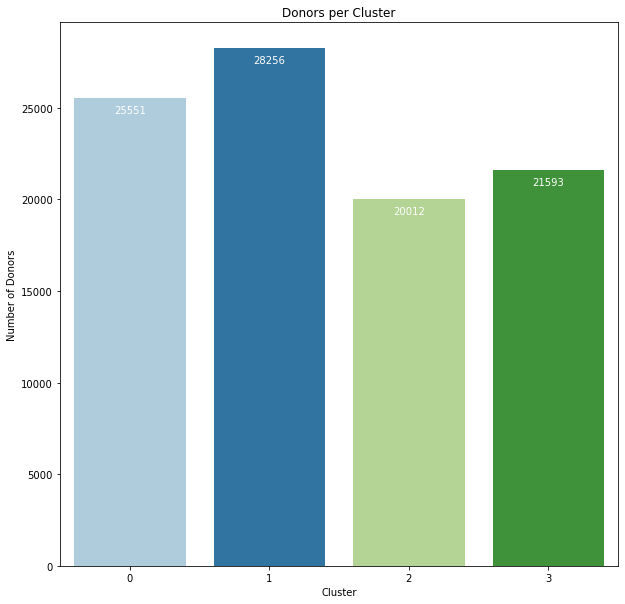

In [8]:
fig = plt.figure(figsize=(10, 10))
graph = sns.countplot(x="Cluster", data=df_profilling, palette = sns.color_palette("Paired"))

graph.set_xlabel("Cluster")
graph.set_ylabel("Number of Donors")
graph.set_title("Donors per Cluster")

# place the value of each category in it's respective bar
for bar in graph.patches:
    graph.annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, -12),
                   color="white",
                   textcoords = 'offset points')

## State distribution

In [9]:
# https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f

In [10]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' column holding
    the geometry information. This uses the pyshp package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]

    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)

    return df

In [11]:
def plot_US_States(sf, title, states,  
                     print_id, color_ton, 
                     bins, 
                     x_lim = None, 
                     y_lim = None, 
                     figsize = (11,9)):
    '''
    Plot map with lim coordinates
    '''
        
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)

    for shape in sf.shapeRecords():
        for i in range(len(shape.shape.parts)):
            i_start = shape.shape.parts[i]
            if i==len(shape.shape.parts)-1:
                i_end = len(shape.shape.points)
            else:
                i_end = shape.shape.parts[i+1]
            x = [i[0] for i in shape.shape.points[i_start:i_end]]
            y = [i[1] for i in shape.shape.points[i_start:i_end]]
            plt.plot(x, y, 'k')
            
    for id in states:
        shape_ex = sf.shape(id)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        ax.fill(x_lon,y_lat, color_ton[states.index(id)])
        if print_id != False:
            x0 = np.mean(x_lon)
            y0 = np.mean(y_lat)
            plt.text(x0, y0, id, fontsize=10)
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)
        
#     fig.savefig(title);

In [12]:
statecode = pd.read_csv('US_Name2Code.txt')
df_states = df_profilling.merge(statecode,left_on='STATE', right_on='Code',how='inner')
MedianClusterPerState = np.floor(df_states[['Name','Cluster']].groupby('Name').Cluster.median())
avgClusterPerState = np.ceil(df_states[['Name','Cluster']].groupby('Name').Cluster.mean())
ModeClusterPerState = df_states[['Name','Cluster']].groupby('Name').Cluster.agg(lambda x:x.value_counts().index[0])
colors = sns.color_palette("Paired").as_hex()[0 : df_states['Cluster'].nunique() ]

<Figure size 1080x648 with 0 Axes>

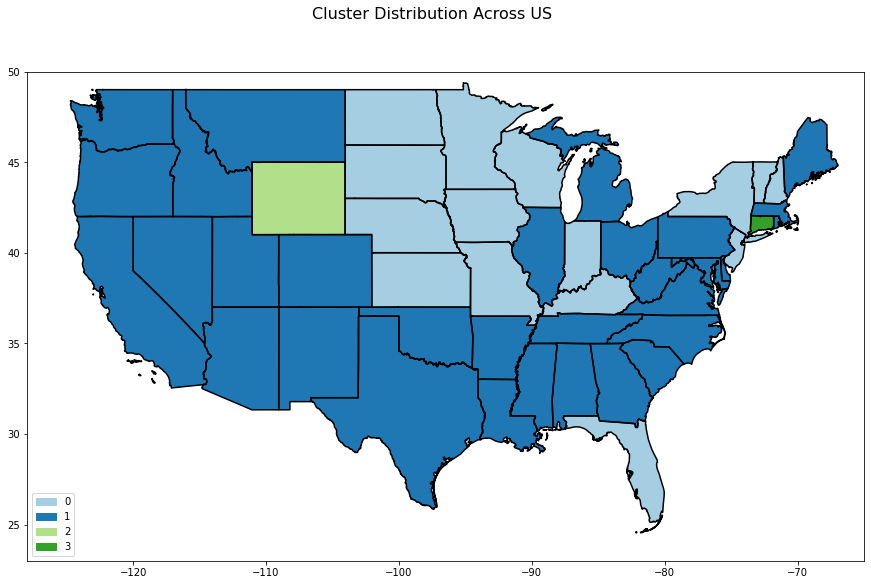

In [14]:
figsize = (15,9)
title = 'Cluster Distribution Across US'
y_lim = (23, 50)
x_lim = (-128, -65)

shp_path = "./US-ShapeFile/st99_d00.shp"
sf = shp.Reader(shp_path)
df_shape = read_shapefile(sf)
plt.figure(figsize = figsize)
fig, ax = plt.subplots(figsize = figsize)
fig.suptitle(title, fontsize=16)

for shape in sf.shapeRecords():
        for i in range(len(shape.shape.parts)):
            i_start = shape.shape.parts[i]
            if i==len(shape.shape.parts)-1:
                i_end = len(shape.shape.points)
            else:
                i_end = shape.shape.parts[i+1]
            x = [i[0] for i in shape.shape.points[i_start:i_end]]
            y = [i[1] for i in shape.shape.points[i_start:i_end]]
            plt.plot(x, y, 'k')
            
plt.xlim(x_lim)
plt.ylim(y_lim)
    
for State in df_states.Name.unique():
    Shapes = list(df_shape[df_shape['NAME'] == State].index)
    for Shape in Shapes:
        shape_ex = sf.shape(Shape)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        ax.fill(x_lon,y_lat, colors[int(ModeClusterPerState.loc[State])])

legends = [mpatches.Patch(color=c, label=f'{i}') for i,c in enumerate(colors)]
plt.legend(handles=legends)